In [2]:
import sys
import os
import re
import gc
import json
import logging
import requests
import itertools
import numba

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse.csr import csr_matrix
from time import sleep


from tqdm.auto import trange, tqdm
from collections import Counter, defaultdict
from scipy.sparse import hstack
import pickle
from torch.utils.data import Dataset
from glob import glob
from IPython.display import display as ipython_displpay
from IPython.display import HTML

In [3]:
prefix = os.getcwd().split('jdi-qasp-ml')[0]
sys.path.append(os.path.join(prefix, 'jdi-qasp-ml'))

model_path = os.path.join(prefix, 'jdi-qasp-ml', 'Old_model/model')
dataset_path = os.path.join(prefix, 'jdi-qasp-ml', 'data/mui_dataset')

In [4]:
# WORKING_DIR = re.sub('jdi-qasp-ml.*$','',os.path.normpath(os.getcwd())) + 'jdi-qasp-ml'
# os.chdir(WORKING_DIR)

In [5]:
# WORKING_DIR

In [6]:

from utils.dataset_builder import DatasetBuilder
from utils.common import maximize_window

2021-11-17 09:50:58,364 -INFO - config.py:31 - Module utils.config was loaded
2021-11-17 09:50:58,396 -INFO - common.py:127 - Module utils.common is loaded...
2021-11-17 09:50:58,397 -INFO - dataset_builder.py:217 - dataset package is loaded...


In [7]:
WAIT_TIME_SECONDS = 3

In [8]:
os.getcwd()

'/Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/notebooks/MUI/Test-backend'

### Predicting

In [9]:
DATASET_NAME = 'material-ui-Buttons'
WAIT_TIME_SECONDS = 7
SITE_URL = 'https://jdi-testing.github.io/jdi-light/'
# SITE_URL = 'https://jdi-testing.github.io/jdi-light/material/buttons'
PREDICT_URL = 'http://localhost:5050/predict'

LOGIN = 'Roman'
PASSWORD = 'Jdi1234'
SAVE_SCREEN = True
WAIT_TIME_SECONDS = 7
# HEADLESS = True

In [10]:
# DATASET_NAME = 'mui-site122'

In [11]:
# SITE_URL = 'C:/WORK/jdi-qasp-ml/MUI_model/dataset/build/site122/index.html'

In [12]:
# PREDICT_URL = 'http://localhost:5000/mui-predict'

In [13]:
dataset_path

'/Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/mui_dataset/dataset'

2021-11-17 09:51:03,203 -INFO - dataset_builder.py:82 - Dataset name: material-ui-Buttons
2021-11-17 09:51:03,205 -INFO - dataset_builder.py:92 - Create directories to save the dataset
2021-11-17 09:51:03,207 -INFO - dataset_builder.py:130 - Creating driver
2021-11-17 09:51:04,153 -INFO - dataset_builder.py:141 - Chrome web driver is created


/Users/Mikhail_Bulgakov/opt/anaconda3/envs/jdi-qasp-ml/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  # This is added back by InteractiveShellApp.init_path()
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/jdi-qasp-ml/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  if sys.path[0] == '':
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/jdi-qasp-ml/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  del sys.path[0]
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/jdi-qasp-ml/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  
/Users/Mikhail_Bulgakov/opt/anaconda3/envs/jdi-qasp-ml/lib/python3.7/site

2021-11-17 09:51:16,552 -INFO - common.py:30 - Window maximized
2021-11-17 09:51:23,557 -INFO - dataset_builder.py:144 - save scrinshot: /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/mui_dataset/dataset/images/material-ui-Buttons.png
2021-11-17 09:51:30,539 -INFO - dataset_builder.py:188 - Collect features using JS script
2021-11-17 09:51:31,280 -INFO - dataset_builder.py:196 - Save html to /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/mui_dataset/dataset/html/material-ui-Buttons.html
2021-11-17 09:51:31,299 -INFO - dataset_builder.py:206 - Save parquet to /Users/Mikhail_Bulgakov/GitRepo/jdi-qasp-ml/data/mui_dataset/dataset/df/material-ui-Buttons.pkl
2021-11-17 09:51:31,302 -INFO - dataset_builder.py:208 - No attributes: (15, 13)
2021-11-17 09:51:36,356 -INFO - dataset_builder.py:107 - Close web driver


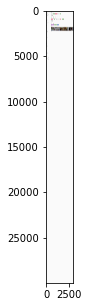

In [14]:
class DSBuilder(DatasetBuilder):
    def setUp(self, driver):
        """
            This method may be overwitten if you need to login to the site
            and navigate to a specific url,
            otherwise it just returns 
        """
        
        driver.set_window_size(width=1500, height=15000)
        self.driver.get(self.url)
        driver.find_element_by_id("user-icon").click()
        driver.find_element_by_id("name").send_keys(LOGIN)
        driver.find_element_by_id("password").send_keys(PASSWORD)
        driver.find_element_by_id("login-button").click()
        sleep(WAIT_TIME_SECONDS)
        driver.find_element_by_xpath("/html/body/div/div[1]/div/div[1]/div/div[1]/ul/li[5]/a/div").click()
        driver.find_element_by_xpath("/html/body/div/div[1]/div/div[1]/div/div[1]/ul/li[5]/ul/li[8]/a").click()
        driver.find_element_by_xpath("/html/body/div/div/div/div[1]/div/div[2]/div/div").click()
        sleep(3.0)
        maximize_window(driver=driver, extend_pix=0)
        sleep(7.0)
        
with DSBuilder(url=SITE_URL, dataset_name=DATASET_NAME, headless=True, dataset_root_path=dataset_path) as builder:
    df = builder.dataset
    dataset_json = builder.dataset_json
    plt.figure(figsize = (20,5))
    plt.imshow(plt.imread(f'{dataset_path}/images/{DATASET_NAME}.png'))

In [15]:
dataset_json

[{'attributes': {'lang': 'en'},
  'displayed': True,
  'element_id': '2353986770318905440239348870',
  'height': 2688,
  'onmouseenter': None,
  'onmouseover': None,
  'parent_id': None,
  'style': ['accent-color',
   'align-content',
   'align-items',
   'align-self',
   'alignment-baseline',
   'animation-delay',
   'animation-direction',
   'animation-duration',
   'animation-fill-mode',
   'animation-iteration-count',
   'animation-name',
   'animation-play-state',
   'animation-timing-function',
   'app-region',
   'appearance',
   'backdrop-filter',
   'backface-visibility',
   'background-attachment',
   'background-blend-mode',
   'background-clip',
   'background-color',
   'background-image',
   'background-origin',
   'background-position',
   'background-repeat',
   'background-size',
   'baseline-shift',
   'block-size',
   'border-block-end-color',
   'border-block-end-style',
   'border-block-end-width',
   'border-block-start-color',
   'border-block-start-style',
   'b

In [16]:
%%time

response = requests.post(
    PREDICT_URL, data=json.dumps(dataset_json)
)

if response.status_code == 200:
    display(json.loads(response.text))
else:
    raise Exception(response.text)

[{'element_id': '4357614304318905441303542665',
  'x': 274.0,
  'y': 895.84375,
  'width': 480.796875,
  'height': 200.0,
  'predicted_label': 'button',
  'predicted_probability': 0.999953866,
  'sort_key': 96159.375},
 {'element_id': '2818435511318905446910787948',
  'x': 1115.390625,
  'y': 895.84375,
  'width': 360.59375,
  'height': 200.0,
  'predicted_label': 'button',
  'predicted_probability': 0.9998182654,
  'sort_key': 72118.75},
 {'element_id': '6600689929318905440480442004',
  'x': 754.796875,
  'y': 895.84375,
  'width': 360.59375,
  'height': 200.0,
  'predicted_label': 'button',
  'predicted_probability': 0.9999980927,
  'sort_key': 72118.75},
 {'element_id': '8979993330318905441284774316',
  'x': 0.0,
  'y': 1536.0,
  'width': 250.0,
  'height': 48.0,
  'predicted_label': 'button',
  'predicted_probability': 0.9159719944,
  'sort_key': 12000.0},
 {'element_id': '5023914525318905441098147534',
  'x': 0.0,
  'y': 1776.0,
  'width': 250.0,
  'height': 48.0,
  'predicted_lab

CPU times: user 75 ms, sys: 20.2 ms, total: 95.2 ms
Wall time: 2.35 s


In [17]:
from utils.common import load_gray_image
from matplotlib.patches import Rectangle

In [18]:
df = pd.read_pickle(f'{dataset_path}/df/{DATASET_NAME}.pkl')[['element_id', 'tag_name']]
df['element_id'] = df['element_id'].astype(str)
preds = pd.DataFrame(json.loads(response.text))
preds['element_id'] = preds['element_id'].astype(str)
predictions_df = preds.merge(df, on='element_id')
predictions_df.head()

element_id            x           y       width  height  \
0  4357614304318905441303542665   274.000000   895.84375  480.796875   200.0   
1  2818435511318905446910787948  1115.390625   895.84375  360.593750   200.0   
2  6600689929318905440480442004   754.796875   895.84375  360.593750   200.0   
3  8979993330318905441284774316     0.000000  1536.00000  250.000000    48.0   
4  5023914525318905441098147534     0.000000  1776.00000  250.000000    48.0   

  predicted_label  predicted_probability   sort_key tag_name  
0          button               0.999954  96159.375   BUTTON  
1          button               0.999818  72118.750   BUTTON  
2          button               0.999998  72118.750   BUTTON  
3          button               0.915972  12000.000      DIV  
4          button               0.915972  12000.000      DIV

In [19]:
preds

element_id            x           y       width  height  \
0   4357614304318905441303542665   274.000000   895.84375  480.796875   200.0   
1   2818435511318905446910787948  1115.390625   895.84375  360.593750   200.0   
2   6600689929318905440480442004   754.796875   895.84375  360.593750   200.0   
3   8979993330318905441284774316     0.000000  1536.00000  250.000000    48.0   
4   5023914525318905441098147534     0.000000  1776.00000  250.000000    48.0   
..                           ...          ...         ...         ...     ...   
95  7228568737318905447250138079   747.859375   146.21875   64.000000    36.5   
96  9114037425318905442938942101   282.000000   594.09375   48.000000    48.0   
97  1206844947318905447077600643   346.000000   594.09375   48.000000    48.0   
98  4850764545318905440329469367   410.000000   594.09375   48.000000    48.0   
99  8789523623318905448589970449   474.000000   594.09375   48.000000    48.0   

   predicted_label  predicted_probability   sort_key  
0           button               0.999954  96159.375  
1           button               0.999818  72118.750  
2           button               0.999998  72118.750  
3           button               0.915972  12000.000  
4           button               0.915972  12000.000  
..             ...                    ...        ...  
95            link               0.999994   2336.000  
96          button               0.999985   2304.000  
97          button               0.999975   2304.000  
98          button               0.999997   2304.000  
99          button               0.999988   2304.000  

[100 rows x 8 columns]

In [20]:
from_pkl = pd.read_pickle(f'{dataset_path}/df/{DATASET_NAME}.pkl')
from_pkl[from_pkl.element_id == '1049561488694071642269580342']

Empty DataFrame
Columns: [attributes, displayed, element_id, height, onmouseenter, onmouseover, parent_id, style, tag_name, text, width, x, y]
Index: []

In [21]:
# set(df.element_id.values).intersection(set(preds.element_id.values))

<AxesSubplot:>

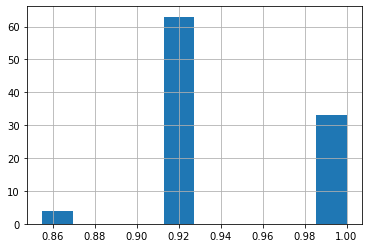

In [22]:
predictions_df['predicted_probability'].hist()

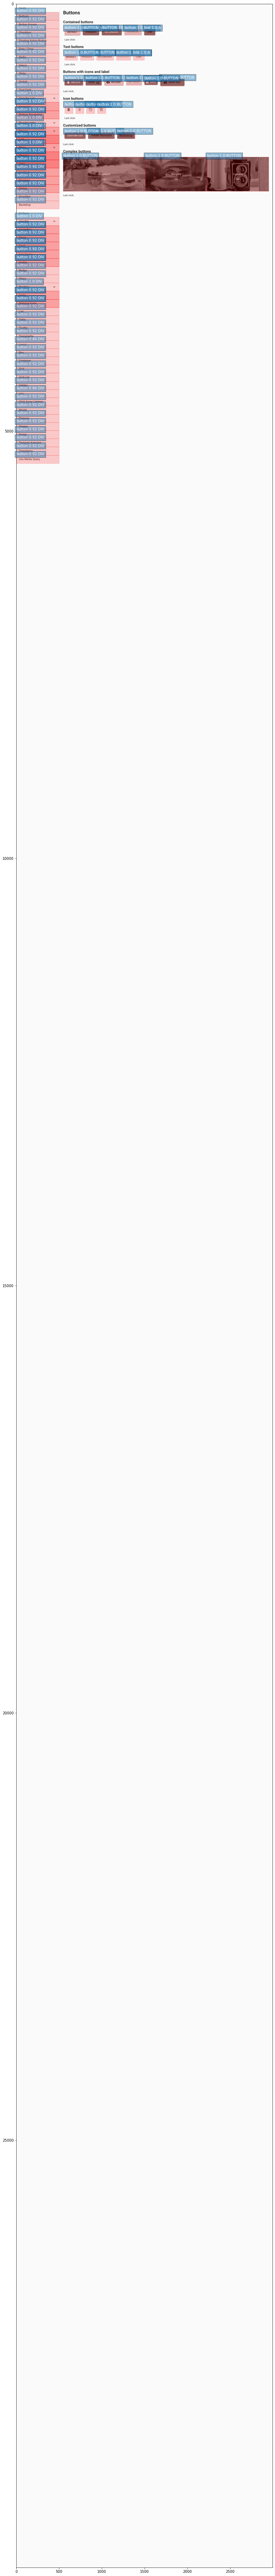

In [23]:
img = load_gray_image(f'{dataset_path}/images/{DATASET_NAME}.png')
plt.figure(figsize=(13,300))
plt.imshow(img, cmap='gray')

axes = plt.gca()

for _, r in predictions_df.iterrows():
    if r.predicted_probability > 0.0:
        patch = Rectangle((r.x*2, r.y*2), r.width*2, r.height*2, alpha=.2, color='red')
        axes.add_patch(patch)
        axes.text(r.x*2, r.y*2, 
                r.predicted_label + ':' +str(round(r.predicted_probability, 2)) + ':' + r.tag_name, 
                backgroundcolor='black', 
                color='white',
                bbox=dict(alpha=0.5))